In [24]:
from feature_engine.encoding import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import spacy

RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'

## Step 1 - Taking a look at the data

For this experimentation, we will try a simple text classification. But first, we must try to understand how many classes we have and how imbalanced they are.

In [25]:
try:
    df = pd.read_parquet(INTERIM_FOLDER+'complaints.pqt')
except:
    df = pd.read_csv(RAW_FOLDER+'complaints.csv')
    df.to_parquet(INTERIM_FOLDER+'complaints.pqt')

print("Number of nulls per feature:")
df.isnull().sum()[df.isnull().sum()>=1].sort_values(ascending=False)

Number of nulls per feature:


Tags                            2010640
Consumer disputed?              1523773
Consumer complaint narrative    1496784
Company public response         1346931
Consumer consent provided?       723261
Sub-issue                        632163
Sub-product                      235164
ZIP code                         221074
State                             37959
Company response to consumer          1
dtype: int64

In [26]:
df_cleaned = df.loc[
    ~df["Consumer complaint narrative"].isnull(), ["Date received", "Consumer complaint narrative", "Company", "Issue", "Product"]
    ]

df_cleaned.sort_values(by="Date received", ascending=False, inplace=True)

print(f"""A) Total number of observations: {len(df)}
B) Observations without NaNs: {len(df_cleaned)}
Proportion B/A: {round(100 * len(df_cleaned) / len(df))}% \n""")

df_cleaned["Date received"] = df_cleaned["Date received"].astype('datetime64[ns]').dt.date
df_cleaned.to_parquet(INTERIM_FOLDER+'df_cleaned.pqt')
df_cleaned.head(10)

A) Total number of observations: 2292232
B) Observations without NaNs: 795448
Proportion B/A: 35% 



,Date received,Consumer complaint narrative,Company,Issue,Product
365538,2021-09-21,Received a call on my mobile; did not answer. ...,"CITIBANK, N.A.",Managing an account,Checking or savings account
139890,2021-09-21,In XXXX and XXXX 2021 I filed a dispute with t...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Problem with a credit reporting company's inve...,"Credit reporting, credit repair services, or o..."
295357,2021-09-21,I am a victim of identity theft. XXXX XXXX XXX...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Incorrect information on your report,"Credit reporting, credit repair services, or o..."
330659,2021-09-21,I have previously submitted several complaints...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Problem with a credit reporting company's inve...,"Credit reporting, credit repair services, or o..."
331225,2021-09-21,I have sent numerous of letters stating facts ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Problem with a credit reporting company's inve...,"Credit reporting, credit repair services, or o..."
330580,2021-09-21,I have tried to send my disputes to the major ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Problem with a credit reporting company's inve...,"Credit reporting, credit repair services, or o..."
282859,2021-09-21,I checked my credit report and found that my m...,NATIONSTAR MORTGAGE,Incorrect information on your report,Mortgage
284502,2021-09-21,The latest credit report I checked still shows...,WELLS FARGO & COMPANY,Problem with a credit reporting company's inve...,"Credit reporting, credit repair services, or o..."
153513,2021-09-21,"Around XX/XX/2021, I noticed a collection appe...","Southwest Recovery Services, Inc.",Incorrect information on your report,"Credit reporting, credit repair services, or o..."
392495,2021-09-21,My checking account has overdraft protection a...,UNITED SERVICES AUTOMOBILE ASSOCIATION,Managing an account,Checking or savings account


In [27]:
df_cleaned.sort_values(by="Issue", inplace=True)
df_cleaned.head(10)

,Date received,Consumer complaint narrative,Company,Issue,Product
1798352,2015-09-21,Opened a credit card account in XX/XX/XXXX. In...,JPMORGAN CHASE & CO.,APR or interest rate,Credit card
1947691,2016-08-02,I have a credit card for our business with 5/3...,FIFTH THIRD FINANCIAL CORPORATION,APR or interest rate,Credit card
1850494,2015-11-04,I have been a Discover credit card member sinc...,DISCOVER BANK,APR or interest rate,Credit card
1872829,2016-05-20,XXXX/XXXX/XXXX made a purchase for {$2500.00} ...,"CITIBANK, N.A.",APR or interest rate,Credit card
1851488,2015-12-17,I have been making automated payments for seve...,"CITIBANK, N.A.",APR or interest rate,Credit card
1965147,2017-02-05,I recieved promotional checks from Chase XXXX ...,JPMORGAN CHASE & CO.,APR or interest rate,Credit card
1826904,2015-06-10,I have a Capital One Credit Card with a promot...,CAPITAL ONE FINANCIAL CORPORATION,APR or interest rate,Credit card
1934304,2015-08-21,I applied for a credit card with Wells Fargo a...,WELLS FARGO & COMPANY,APR or interest rate,Credit card
1839816,2017-01-23,This morning I receive an email notification f...,JPMORGAN CHASE & CO.,APR or interest rate,Credit card
1883782,2015-06-17,I visit a XXXX office XXXX XXXX XXXX. I was to...,SYNCHRONY FINANCIAL,APR or interest rate,Credit card


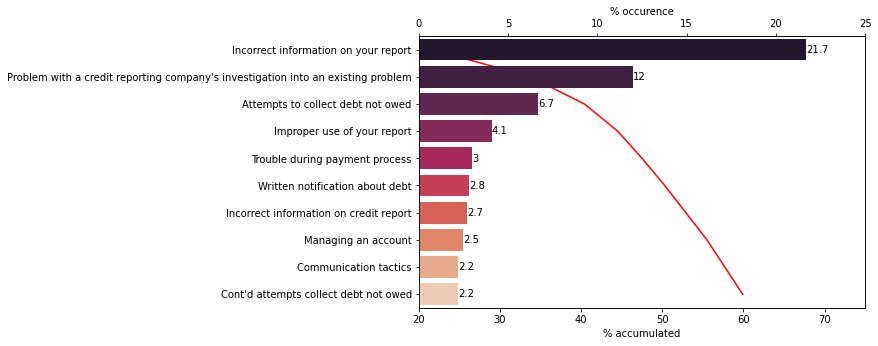

In [95]:
count_issues = pd.DataFrame(100*df_cleaned["Issue"].value_counts()/df_cleaned["Issue"].value_counts().sum())
count_issues.rename(columns={"Issue": "% occurence"}, inplace=True)
count_issues["% accumulated"] = count_issues["% occurence"].cumsum()

count_issues = count_issues[count_issues["% occurence"]>=2]
count_issues = round(count_issues, 1)

a4_dims = (8, 5)
fig, ax = plt.subplots(figsize=a4_dims)

# sns.color_palette("rocket", as_cmap=True)
ax = sns.lineplot(data=count_issues, x=count_issues["% accumulated"], y=count_issues.index, color="red")
ax.set_xlim(20,75)
ax1 = plt.twiny()
ax2 = sns.barplot(x=count_issues["% occurence"], y=count_issues.index, ax=ax1, palette='rocket')
ax2.set_xlim(0,25)
ax2.bar_label(ax2.containers[0]);

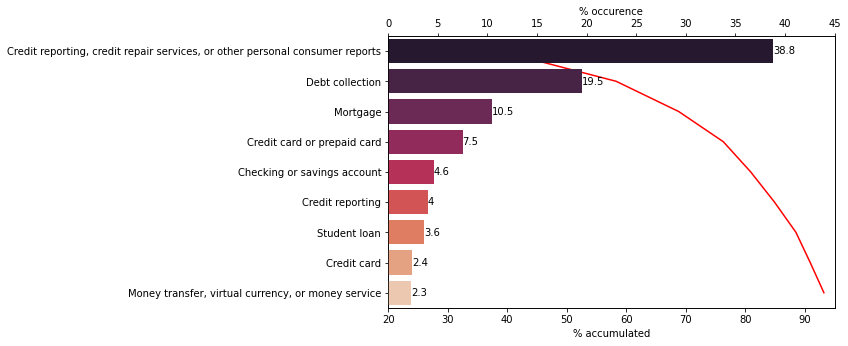

In [100]:
count_product = pd.DataFrame(100*df_cleaned["Product"].value_counts()/df_cleaned["Product"].value_counts().sum())
count_product.rename(columns={"Product": "% occurence"}, inplace=True)
count_product["% accumulated"] = count_product["% occurence"].cumsum()

count_product = count_product[count_product["% occurence"]>=2]
count_product = round(count_product, 1)

a4_dims = (8, 5)
fig, ax = plt.subplots(figsize=a4_dims)

# sns.color_palette("rocket", as_cmap=True)
ax = sns.lineplot(data=count_product, x=count_product["% accumulated"], y=count_product.index, color="red")
ax.set_xlim(20, 95)
ax1 = plt.twiny()
ax2 = sns.barplot(x=count_product["% occurence"], y=count_product.index, ax=ax1, palette='rocket')
ax2.set_xlim(0, 45)
ax2.bar_label(ax2.containers[0]);

### Comments

In this notebook, I'm still trying to narrow the problem. As we have so many imbalanced classes on **Issue** and **Product**, I will proceed with the following:

1. Create a new feature called "treated_product", because there are classes that are similar (e.g.: "Credit card" and "Credit card or prepaid card")
1. Cluster the most rare classes into a "Other products" class at **Product** feature;
1. Classify the "treated_product" using "Consumer complaint narrative" as predictor.